In [1]:
import pandas as pd
import numpy as np
import jieba
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
# 加载训练集和测试集数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
# 分词处理
def tokenize(text):
    return ' '.join(jieba.cut(text))

train_data['content'] = train_data['content'].apply(tokenize)
train_data['title'] = train_data['title'].apply(tokenize)
train_data['tag'] = train_data['tag'].apply(tokenize)
test_data['content'] = test_data['content'].apply(tokenize)
test_data['title'] = test_data['title'].apply(tokenize)
test_data['tag'] = test_data['tag'].apply(tokenize)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\13414\AppData\Local\Temp\jieba.cache
Loading model cost 0.485 seconds.
Prefix dict has been built successfully.


In [4]:
# 创建词汇表
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['content'].tolist() + train_data['title'].tolist() + train_data['tag'].tolist())

In [5]:
# 将文本转化为序列
train_content_seq = tokenizer.texts_to_sequences(train_data['content'].tolist())
train_title_seq = tokenizer.texts_to_sequences(train_data['title'].tolist())
train_tag_seq = tokenizer.texts_to_sequences(train_data['tag'].tolist())
test_content_seq = tokenizer.texts_to_sequences(test_data['content'].tolist())
test_title_seq = tokenizer.texts_to_sequences(test_data['title'].tolist())
test_tag_seq = tokenizer.texts_to_sequences(test_data['tag'].tolist())

In [6]:
# 对序列进行填充
maxlen = 500
train_content_seq = pad_sequences(train_content_seq, padding='post', maxlen=maxlen)
train_title_seq = pad_sequences(train_title_seq, padding='post', maxlen=maxlen)
train_tag_seq = pad_sequences(train_tag_seq, padding='post', maxlen=maxlen)
test_content_seq = pad_sequences(test_content_seq, padding='post', maxlen=maxlen)
test_title_seq = pad_sequences(test_title_seq, padding='post', maxlen=maxlen)
test_tag_seq = pad_sequences(test_tag_seq, padding='post', maxlen=maxlen)

In [7]:
# 构建模型
input_content = Input(shape=(maxlen,))
input_title = Input(shape=(maxlen,))
input_tag = Input(shape=(maxlen,))

In [8]:
embedding_dim = 32
lstm_units = 64
dropout_rate = 0.2

embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=maxlen)
lstm_layer = LSTM(units=lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True)

content_embedding = embedding_layer(input_content)
content_lstm = lstm_layer(content_embedding)

title_embedding = embedding_layer(input_title)
title_lstm = lstm_layer(title_embedding)

tag_embedding = embedding_layer(input_tag)
tag_lstm = lstm_layer(tag_embedding)

merged = Bidirectional(LSTM(units=lstm_units))(content_lstm)
merged = Dense(units=16, activation='relu')(merged)
merged = Dense(units=1, activation='sigmoid')(merged)

model = Model(inputs=[input_content,input_title,input_tag], outputs=merged)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# 训练模型
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x=[train_content_seq, train_title_seq, train_tag_seq], y=train_data['label'].values, batch_size=64,
                    epochs=20, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20
57/57 [==============================] - 76s 1s/step - loss: 0.6696 - accuracy: 0.5632 - val_loss: 0.5771 - val_accuracy: 0.7175
Epoch 2/20
57/57 [==============================] - 78s 1s/step - loss: 0.4256 - accuracy: 0.8160 - val_loss: 0.4539 - val_accuracy: 0.7725
Epoch 3/20
57/57 [==============================] - 81s 1s/step - loss: 0.2482 - accuracy: 0.9019 - val_loss: 0.5216 - val_accuracy: 0.7600
Epoch 4/20
57/57 [==============================] - 82s 1s/step - loss: 0.1413 - accuracy: 0.9483 - val_loss: 0.6155 - val_accuracy: 0.7775
Epoch 5/20
57/57 [==============================] - 86s 2s/step - loss: 0.0850 - accuracy: 0.9728 - val_loss: 0.8692 - val_accuracy: 0.7700


In [10]:
# 在测试集上进行预测
y_pred = model.predict([test_content_seq, test_title_seq, test_tag_seq])
y_pred = np.round(y_pred).flatten()

32/32 [==============================] - 5s 127ms/step


In [11]:
# 输出结果
accuracy = accuracy_score(test_data['label'].values, y_pred)
precision, recall, f1_score, support = precision_recall_fscore_support(test_data['label'].values, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)
print('Support:', support)

Accuracy: 0.8038038038038038
Precision: [0.81704782 0.79150579]
Recall: [0.78443114 0.82329317]
F1 score: [0.80040733 0.80708661]
Support: [501 498]


In [13]:
# 将预测结果写入文件
test_data['pre_label'] = y_pred
test_data.to_csv('LSTMRes.csv', index=False)

In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
# 计算混淆矩阵
conf_mat = confusion_matrix(test_data['label'], y_pred)

In [16]:
# 可视化混淆矩阵
import seaborn as sns
import matplotlib.pyplot as plt

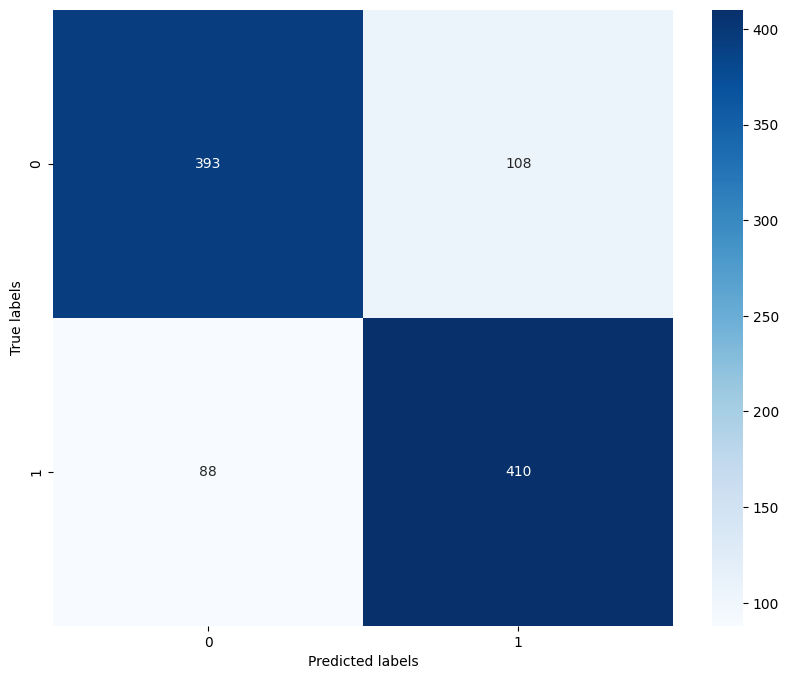

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()